In [51]:
from os import listdir
from os.path import isfile, join

mypath = "./fittings"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

import yaml


In [55]:
all_results = []
for folder in onlyfiles:
    if 'fit' in folder:
        with open("fittings/"+folder) as file:
            r = yaml.load(file, Loader=yaml.UnsafeLoader)
            r['days_ahead'] = int(folder.split("_")[1])
            r['alpha'] = float(folder.split("_")[2])
            r['scenario'] = float(folder.split("_")[4][0])
            all_results.append(r)

In [56]:
r

{'alpha': 1.05,
 'days_ahead': 72,
 'iterations': 50,
 'n_samples': 10,
 'result': [0.6976416955313983, 0.0, 0.0, 0.0, 1.0],
 'scenario': 1.0,
 'value': 9.308044996841057}

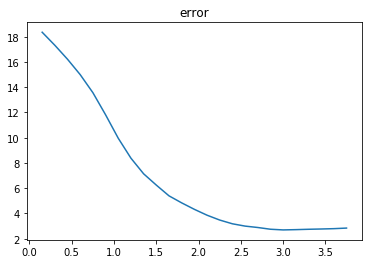

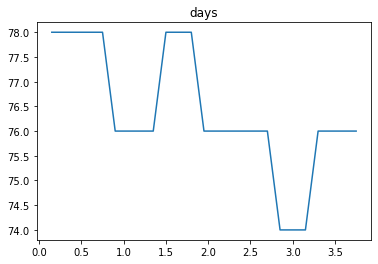

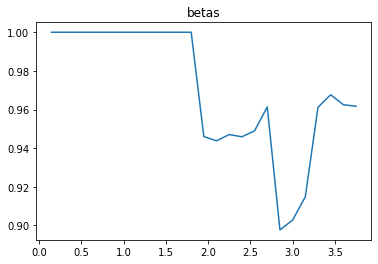

In [61]:
scenario = 0
# Calculate best error
best = {round((a+1)*0.15,2):{"value":float('inf')} for a in range(0,25)}
for r in all_results:
    if r["scenario"] == scenario:
        alpha = r["alpha"]
        days_ahead = r["days_ahead"]
        value = r["value"]
        if value<best[alpha]['value']:
            best[alpha] = {
                "value":value,
                "v":r["result"],
                "days_ahead":r["days_ahead"]
            }
        
vector_of_best = [best[round((a+1)*0.15,2)]["value"] for a in range(0,25)]
vector_of_days = [best[round((a+1)*0.15,2)]["days_ahead"] for a in range(0,25)]
vector_of_betas = [best[round((a+1)*0.15,2)]["v"][0] for a in range(0,25)]


alpha_values = [round((a+1)*0.15,2) for a in range(0,25)]

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

plt.figure(1)
plt.plot(alpha_values, vector_of_best)
plt.title("error")
plt.show()

plt.figure(1)
plt.plot(alpha_values, vector_of_days)
plt.title("days")
plt.show()

plt.figure(1)
plt.plot(alpha_values, vector_of_betas)
plt.title("betas")
plt.show()


In [33]:
best

{0.2: {'value': 19.37469502270464, 'v': [1.0, 1.0, 0.0, 0.0, 0.0, 0.2, 1.0]},
 0.3: {'value': 17.329211622629376,
  'v': [1.0, 1.0, 0.0, 0.0, 0.6920860745337404, 0.2, 0.8805984709827666]},
 0.4: {'value': 14.163018337802612, 'v': [1.0, 1.0, 0.0, 0.0, 0.0, 0.2, 1.0]},
 0.5: {'value': 9.652388474530685, 'v': [1.0, 1.0, 0.0, 0.0, 0.0, 0.2, 1.0]},
 0.6: {'value': 5.7150925519263405,
  'v': [1.0, 1.0, 0.0, 0.0, 0.0, 0.1567764747900073, 1.0]},
 0.7: {'value': 4.217525769971742,
  'v': [0.9259737805020966,
   1.0,
   0.0,
   0.013761994497584633,
   0.0,
   0.19999999980526403,
   0.9999999997741791]},
 0.8: {'value': 3.6149437648518274,
  'v': [0.9119138256249575,
   0.9153029029564034,
   1.319671835307622e-08,
   0.017019694999923164,
   0.05214736549760085,
   0.15908356370133087,
   0.9216205797298592]},
 0.9: {'value': 2.4184835198962116,
  'v': [0.8159061903878363,
   0.9524782032029128,
   0.0,
   0.010662281050323102,
   0.0,
   0.10976215347235321,
   1.0]},
 1.0: {'value': 2.506417